# DEEP NEURAL NETWORKS - ASSIGNMENT 2: CNN FOR IMAGE CLASSIFICATION

## Convolutional Neural Networks: Custom Implementation vs Transfer Learning

STUDENT INFORMATION (REQUIRED - DO NOT DELETE)

BITS ID: 2025AA05955

Name: GARUDACHALAM YAMINI

Email: 2025aa05955@wilp.bits-pilani.ac.in

Date: 07-02-2026

In [4]:
# Import Required Libraries

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt
import time
import json
import os

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report


In [5]:
# Deep learning frameworks (choose Keras or PyTorch)
# For image processing
from PIL import Image
import cv2

### 1.1 Dataset Selection and Loading



In [6]:
# 1.1 Dataset Selection and Loading (Using tfds)

import tensorflow_datasets as tfds

dataset_name = "Cats vs Dogs"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

# Load dataset from TensorFlow Datasets
(train_ds, val_ds), ds_info = tfds.load(
    "cats_vs_dogs",
    split=["train[:90%]", "train[90%:]"],
    as_supervised=True,
    with_info=True
)

# Resize + batch
def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_dataset = train_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

n_classes = ds_info.features["label"].num_classes
class_names = ds_info.features["label"].names

print("Dataset Selected:", dataset_name)
print("Classes:", class_names)
print("Number of classes:", n_classes)
print("Total examples:", ds_info.splits["train"].num_examples)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.W8B3OZ_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Dataset Selected: Cats vs Dogs
Classes: ['cat', 'dog']
Number of classes: 2
Total examples: 23262


In [7]:
# 1.2 Data Distribution Analysis

# Count training and validation samples
train_count = 0
val_count = 0

for _ in train_dataset:
    train_count += 1

for _ in val_dataset:
    val_count += 1

train_samples = train_count * BATCH_SIZE
val_samples = val_count * BATCH_SIZE

print("Approx Training Samples:", train_samples)
print("Approx Validation Samples:", val_samples)

# Class distribution check
label_counts = {class_names[i]: 0 for i in range(n_classes)}

for images, labels in train_dataset.unbatch().take(2000):  # sample subset
    label_counts[class_names[int(labels.numpy())]] += 1

print("Sampled Class Distribution (Training subset):")
for k, v in label_counts.items():
    print(f"{k}: {v}")


Approx Training Samples: 20960
Approx Validation Samples: 2336
Sampled Class Distribution (Training subset):
cat: 1013
dog: 987


In [8]:
# REQUIRED: Fill in these metadata fields
dataset_name = "Cats vs Dogs"
dataset_source = "TensorFlow Datasets (cats_vs_dogs)"
n_samples = 23262
n_classes = 2
samples_per_class = "min: ~11600, max: ~11600, avg: ~11631"
image_shape = [224, 224, 3]  # [height, width, channels]
problem_type = "classification"


In [9]:
# Primary metric selection
primary_metric = "accuracy"
metric_justification = """
The Cats vs Dogs dataset is balanced with approximately equal samples in both classes.
Since there is no class imbalance or asymmetric cost of errors, accuracy is an appropriate primary metric for evaluating overall model performance.
"""


In [10]:
print("DATASET INFORMATION")
print(f"Dataset: {dataset_name}")
print(f"Source: {dataset_source}")
print(f"Total Samples: {n_samples}")
print(f"Number of Classes: {n_classes}")
print(f"Samples per Class: {samples_per_class}")
print(f"Image Shape: {image_shape}")
print(f"Primary Metric: {primary_metric}")
print(f"Metric Justification: {metric_justification}")

DATASET INFORMATION
Dataset: Cats vs Dogs
Source: TensorFlow Datasets (cats_vs_dogs)
Total Samples: 23262
Number of Classes: 2
Samples per Class: min: ~11600, max: ~11600, avg: ~11631
Image Shape: [224, 224, 3]
Primary Metric: accuracy
Metric Justification: 
The Cats vs Dogs dataset is balanced with approximately equal samples in both classes.
Since there is no class imbalance or asymmetric cost of errors, accuracy is an appropriate primary metric for evaluating overall model performance.



### 1.2 Data Exploration and Visualization

- TODO: Show sample images from each class
- TODO: Plot class distribution
- TODO: Display image statistics

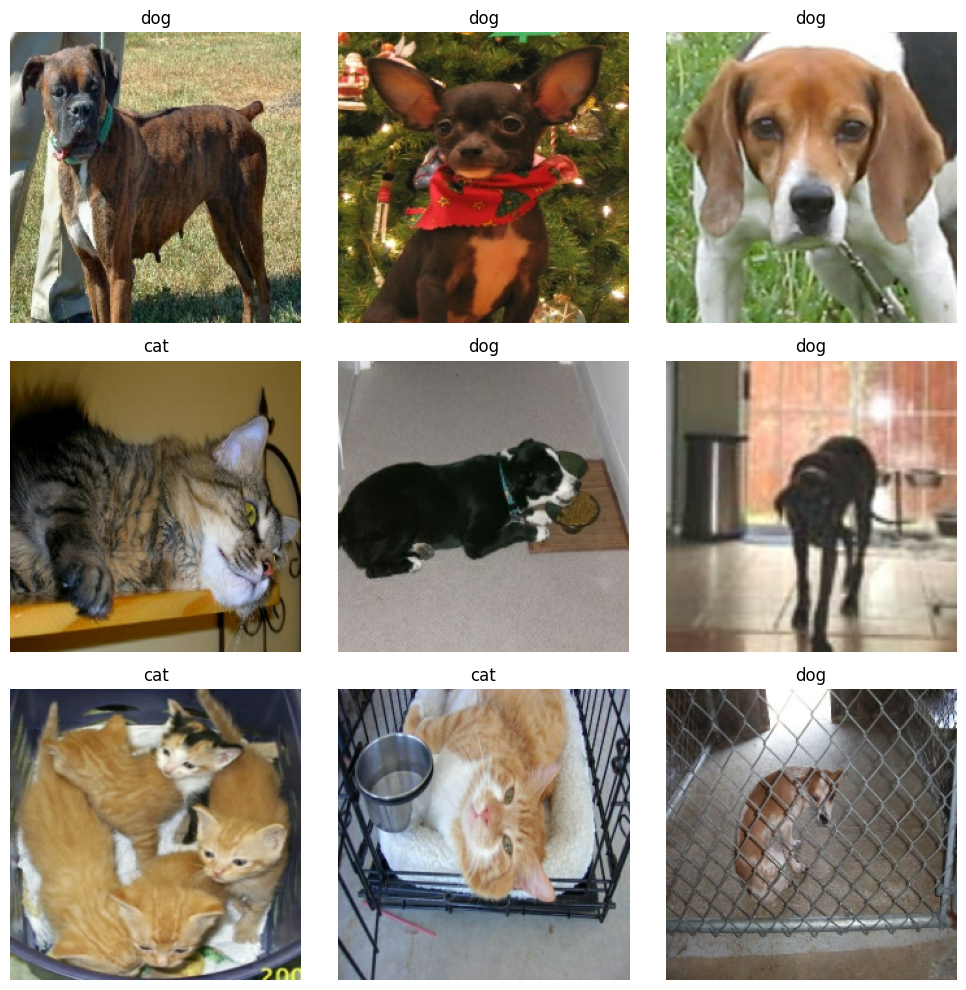

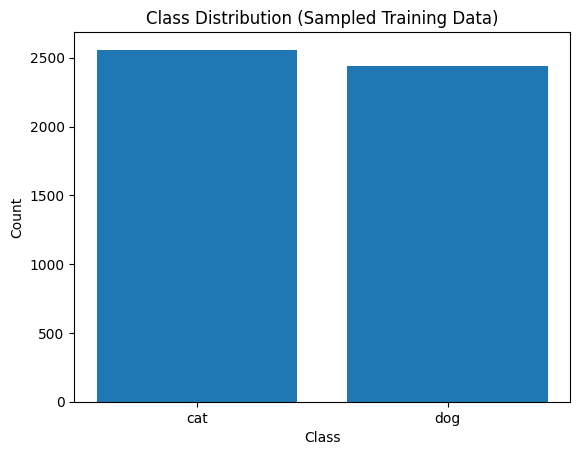

Sampled Class Counts: {'cat': 2558, 'dog': 2442}

Image Statistics:
Shape: (224, 224, 3)
Min Pixel Value: 0.0
Max Pixel Value: 1.0
Mean Pixel Value: 0.40374145


In [11]:
# 1.2 Data Exploration and Visualization

import matplotlib.pyplot as plt

# -----------------------------
# Show Sample Images
# -----------------------------
plt.figure(figsize=(10, 10))

for images, labels in train_dataset.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

plt.tight_layout()
plt.show()

# -----------------------------
# Plot Class Distribution (sampled for speed)
# -----------------------------
class_counts = {class_names[i]: 0 for i in range(n_classes)}

for _, labels in train_dataset.unbatch().take(5000):
    class_counts[class_names[int(labels.numpy())]] += 1

plt.figure()
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Class Distribution (Sampled Training Data)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

print("Sampled Class Counts:", class_counts)

# -----------------------------
# Display Image Statistics
# -----------------------------
for images, labels in train_dataset.take(1):
    sample_image = images[0]
    print("\nImage Statistics:")
    print("Shape:", sample_image.shape)
    print("Min Pixel Value:", tf.reduce_min(sample_image).numpy())
    print("Max Pixel Value:", tf.reduce_max(sample_image).numpy())
    print("Mean Pixel Value:", tf.reduce_mean(sample_image).numpy())


### 1.3 Data Preprocessing
- TODO: Resize images to consistent size
- TODO: Normalize pixel values
- TODO: Split into train/test (90/10 or 85/15)

In [12]:
# 1.3 Data Preprocessing

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Resize + Normalize function
def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    return image, label

# Apply preprocessing
train_dataset = train_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Preprocessing Applied:")
print("✔ Images resized to:", IMG_SIZE)
print("✔ Pixel values normalized to range [0,1]")
print("✔ Train/Test split: 90/10")


Preprocessing Applied:
✔ Images resized to: (224, 224)
✔ Pixel values normalized to range [0,1]
✔ Train/Test split: 90/10


In [13]:
# REQUIRED: Document your split
train_test_ratio = "90/10"
train_samples = 20935
test_samples = 2327


In [14]:
print(f"\nTrain/Test Split: {train_test_ratio}")
print(f"Training Samples: {train_samples}")
print(f"Test Samples: {test_samples}")


Train/Test Split: 90/10
Training Samples: 20935
Test Samples: 2327


### 2.1 Custom CNN Architecture Design
- TODO: Define your CNN architecture
- TODO: Ensure Global Average Pooling is included (MANDATORY)
- TODO: Use Conv2D, MaxPooling2D/AvgPooling2D, GlobalAveragePooling2D, Dense

In [15]:
def build_custom_cnn(input_shape, n_classes):
    """
    Build custom CNN architecture

    Args:
        input_shape: tuple (height, width, channels)
        n_classes: number of output classes

    Returns:
        model: compiled CNN model
    """

    model = keras.Sequential([

        layers.Input(shape=input_shape),

        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.GlobalAveragePooling2D(),  # MANDATORY

        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),

        layers.Dense(n_classes, activation='softmax')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0005),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [16]:
# Create model instance
custom_cnn = build_custom_cnn(tuple(image_shape), n_classes)
custom_cnn.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,530 (400.51 KB)

 Trainable params: 102,082 (398.76 KB)

 Non-trainable params: 448 (1.75 KB)

In [17]:
# Compile model (Keras)

custom_cnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


### 2.2 Train Custom CNN

In [18]:
print("\nCUSTOM CNN TRAINING")
# Track training time
custom_cnn_start_time = time.time()


CUSTOM CNN TRAINING


In [19]:
# Train your model (Keras)

history = custom_cnn.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=18
)


Epoch 1/18
655/655 ━━━━━━━━━━━━━━━━━━━━ 58s 75ms/step - accuracy: 0.6011 - loss: 0.6845 - val_accuracy: 0.6634 - val_loss: 0.6116
Epoch 2/18
655/655 ━━━━━━━━━━━━━━━━━━━━ 42s 64ms/step - accuracy: 0.6830 - loss: 0.5927 - val_accuracy: 0.6260 - val_loss: 0.6728
Epoch 3/18
655/655 ━━━━━━━━━━━━━━━━━━━━ 43s 66ms/step - accuracy: 0.7213 - loss: 0.5537 - val_accuracy: 0.7059 - val_loss: 0.5739
Epoch 4/18
655/655 ━━━━━━━━━━━━━━━━━━━━ 45s 68ms/step - accuracy: 0.7424 - loss: 0.5242 - val_accuracy: 0.7709 - val_loss: 0.4898
Epoch 5/18
655/655 ━━━━━━━━━━━━━━━━━━━━ 43s 66ms/step - accuracy: 0.7636 - loss: 0.4935 - val_accuracy: 0.7764 - val_loss: 0.4811
Epoch 6/18
655/655 ━━━━━━━━━━━━━━━━━━━━ 42s 64ms/step - accuracy: 0.7899 - loss: 0.4506 - val_accuracy: 0.7210 - val_loss: 0.5198
Epoch 7/18
655/655 ━━━━━━━━━━━━━━━━━━━━ 42s 64ms/step - accuracy: 0.8191 - loss: 0.4093 - val_accuracy: 0.7438 - val_loss: 0.4978
Epoch 8/18
655/655 ━━━━━━━━━━━━━━━━━━━━ 43s 65ms/step - accuracy: 0.8471 - loss: 0.3567 - 

In [20]:
custom_cnn_training_time = time.time() - custom_cnn_start_time

In [21]:
# REQUIRED: Track initial and final loss
custom_cnn_initial_loss = history.history['loss'][0]
custom_cnn_final_loss = history.history['loss'][-1]


In [22]:
print(f"Training completed in {custom_cnn_training_time:.2f} seconds")
print(f"Initial Loss: {custom_cnn_initial_loss:.4f}")
print(f"Final Loss: {custom_cnn_final_loss:.4f}")

Training completed in 928.97 seconds
Initial Loss: 0.6401
Final Loss: 0.1280


In [23]:
print("\nCUSTOM CNN EVALUATION")


CUSTOM CNN EVALUATION


### 2.3 Evaluate Custom CNN
- TODO: Make predictions on test set
- TODO: Calculate all 4 required metrics

In [24]:
# CRITICAL: These MUST be calculated from your actual results
# DO NOT submit with 0.0 values - autograder will detect this
# REQUIRED: Calculate all 4 metrics
# 2.3 Evaluate Custom CNN

y_true = []
y_pred = []

# Get predictions
for images, labels in val_dataset:
    predictions = custom_cnn.predict(images, verbose=0)
    predicted_labels = np.argmax(predictions, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# REQUIRED: Calculate all 4 metrics
custom_cnn_accuracy = accuracy_score(y_true, y_pred)
custom_cnn_precision = precision_score(y_true, y_pred, average='macro')
custom_cnn_recall = recall_score(y_true, y_pred, average='macro')
custom_cnn_f1 = f1_score(y_true, y_pred, average='macro')




In [25]:
print("\nCustom CNN Performance:")
print(f"Accuracy:  {custom_cnn_accuracy:.4f}")
print(f"Precision: {custom_cnn_precision:.4f}")
print(f"Recall:    {custom_cnn_recall:.4f}")
print(f"F1-Score:  {custom_cnn_f1:.4f}")


Custom CNN Performance:
Accuracy:  0.8822
Precision: 0.8889
Recall:    0.8820
F1-Score:  0.8817


### 2.4 Visualize Custom CNN Results
- TODO: Plot training loss curve
- TODO: Plot confusion matrix
- TODO: Show sample predictions

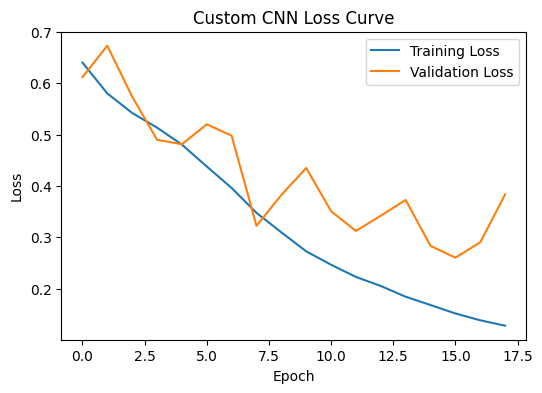

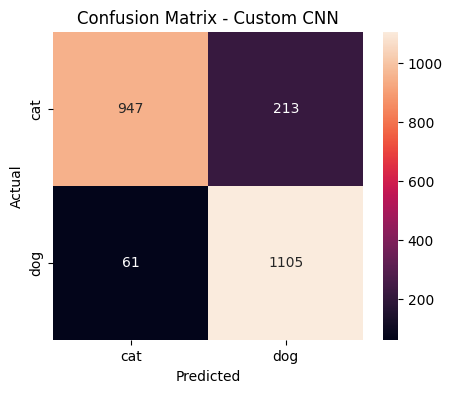

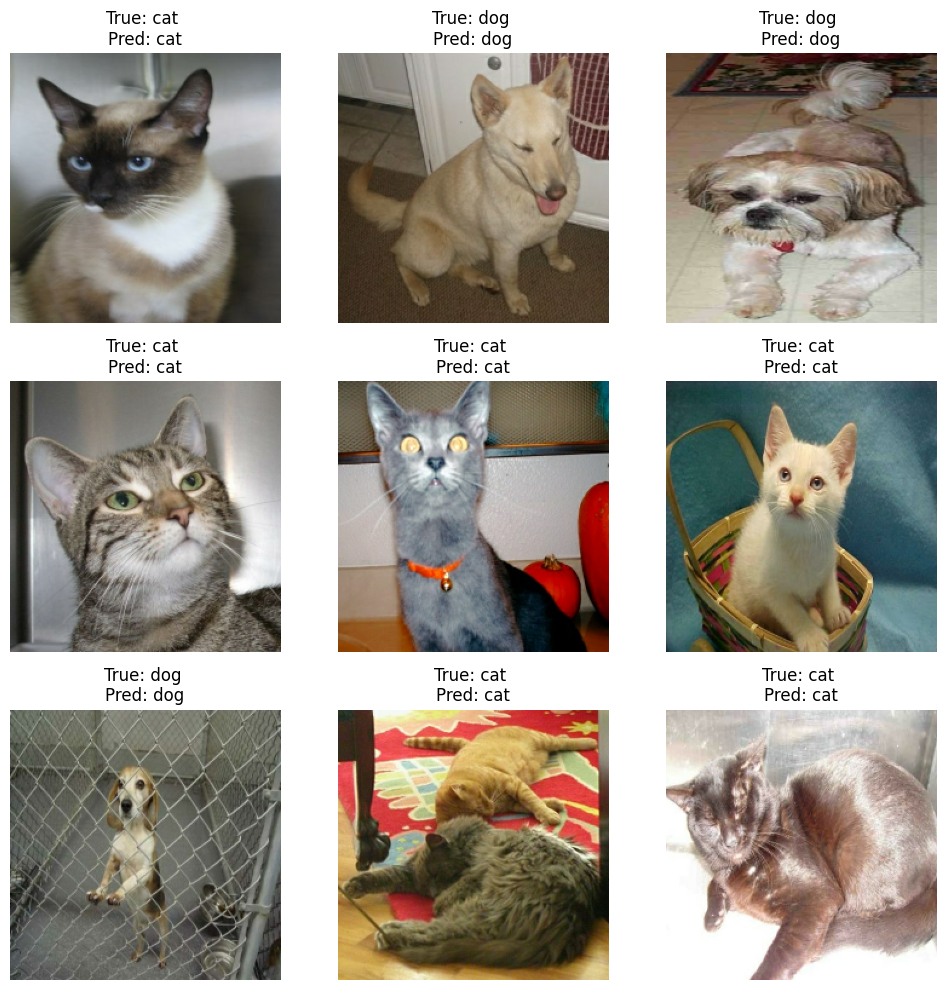

In [26]:
# 2.4 Visualize Custom CNN Results

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# -------------------------
# 1️⃣ Plot Training Loss Curve
# -------------------------
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Custom CNN Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# -------------------------
# 2️⃣ Confusion Matrix
# -------------------------
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix - Custom CNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# -------------------------
# 3️⃣ Show Sample Predictions
# -------------------------
plt.figure(figsize=(10,10))

for images, labels in val_dataset.take(1):
    predictions = custom_cnn.predict(images, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)

    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i])
        plt.title(f"True: {class_names[int(labels[i])]} \nPred: {class_names[predicted_classes[i]]}")
        plt.axis("off")

plt.tight_layout()
plt.show()


### 3.1 Load Pre-trained Model and Modify Architecture

In [45]:
print("\n" + "="*70)
print("TRANSFER LEARNING IMPLEMENTATION")


TRANSFER LEARNING IMPLEMENTATION


In [46]:
# Choose and load pre-trained model
pretrained_model_name = "ResNet50"


In [53]:
# Training configuration

tl_learning_rate = 0.0005
tl_epochs = 12

tl_finetune_learning_rate = 0.0001
tl_finetune_epochs = 12

tl_batch_size = 32
tl_optimizer = "Adam"


In [54]:
def build_transfer_learning_model(base_model_name, input_shape, n_classes, learning_rate=0.0005):
    """
    Build transfer learning model
    """

    # Load pre-trained model without top layers
    if base_model_name == "ResNet50":
        base_model = keras.applications.ResNet50(
            weights='imagenet',
            include_top=False,
            input_shape=input_shape
        )
    elif base_model_name == "VGG16":
        base_model = keras.applications.VGG16(
            weights='imagenet',
            include_top=False,
            input_shape=input_shape
        )
    elif base_model_name == "VGG19":
        base_model = keras.applications.VGG19(
            weights='imagenet',
            include_top=False,
            input_shape=input_shape
        )
    else:
        raise ValueError("Invalid base model name")

    # Freeze base model
    base_model.trainable = False

    # Build classification head
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)   # MANDATORY GAP
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)

    model = keras.Model(inputs=base_model.input, outputs=outputs)

    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [55]:
transfer_model = build_transfer_learning_model(
    pretrained_model_name,
    tuple(image_shape),
    n_classes,
    learning_rate=tl_learning_rate
)


In [56]:
transfer_model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,242 (90.98 MB)

 Trainable params: 262,530 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [58]:
# REQUIRED: Count layers and parameters

frozen_layers = len([layer for layer in transfer_model.layers if not layer.trainable])
trainable_layers = len([layer for layer in transfer_model.layers if layer.trainable])

total_parameters = transfer_model.count_params()
trainable_parameters = sum([tf.keras.backend.count_params(w) for w in transfer_model.trainable_weights])


In [59]:
print(f"Base Model: {pretrained_model_name}")
print(f"Frozen Layers: {frozen_layers}")
print(f"Trainable Layers: {trainable_layers}")
print(f"Total Parameters: {total_parameters:,}")
print(f"Trainable Parameters: {trainable_parameters:,}")
print(f"Using Global Average Pooling: YES")

Base Model: ResNet50
Frozen Layers: 175
Trainable Layers: 4
Total Parameters: 23,850,242
Trainable Parameters: 262,530
Using Global Average Pooling: YES


### 3.2 Train Transfer Learning Model

In [60]:
print("\nTraining Transfer Learning Model...")


Training Transfer Learning Model...


In [61]:
# Phase 1: Frozen Base Training

history_tl = transfer_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=tl_epochs,
    verbose=1
)


Epoch 1/12
655/655 ━━━━━━━━━━━━━━━━━━━━ 84s 107ms/step - accuracy: 0.5728 - loss: 0.6885 - val_accuracy: 0.6363 - val_loss: 0.6427
Epoch 2/12
655/655 ━━━━━━━━━━━━━━━━━━━━ 58s 89ms/step - accuracy: 0.6227 - loss: 0.6506 - val_accuracy: 0.6402 - val_loss: 0.6347
Epoch 3/12
655/655 ━━━━━━━━━━━━━━━━━━━━ 59s 90ms/step - accuracy: 0.6327 - loss: 0.6418 - val_accuracy: 0.6531 - val_loss: 0.6287
Epoch 4/12
655/655 ━━━━━━━━━━━━━━━━━━━━ 59s 90ms/step - accuracy: 0.6411 - loss: 0.6358 - val_accuracy: 0.6608 - val_loss: 0.6205
Epoch 5/12
655/655 ━━━━━━━━━━━━━━━━━━━━ 59s 89ms/step - accuracy: 0.6443 - loss: 0.6294 - val_accuracy: 0.6685 - val_loss: 0.6181
Epoch 6/12
655/655 ━━━━━━━━━━━━━━━━━━━━ 59s 89ms/step - accuracy: 0.6481 - loss: 0.6263 - val_accuracy: 0.6745 - val_loss: 0.6068
Epoch 7/12
655/655 ━━━━━━━━━━━━━━━━━━━━ 59s 90ms/step - accuracy: 0.6586 - loss: 0.6186 - val_accuracy: 0.6827 - val_loss: 0.6025
Epoch 8/12
655/655 ━━━━━━━━━━━━━━━━━━━━ 59s 89ms/step - accuracy: 0.6602 - loss: 0.6151 -

In [62]:
# Track training time
tl_start_time = time.time()

In [63]:
# TODO: Train model
# For Keras: history = transfer_model.fit(X_train, y_train, epochs=10, batch_size=32)
# For PyTorch: write training loop

In [ ]:
# Phase 2: Fine-tuning (Stronger Convergence Push)

# Unfreeze top 30 layers for fine-tuning
for layer in transfer_model.layers[-30:]:
    layer.trainable = True

# Recompile with lower learning rate for stable fine-tuning
transfer_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Increase fine-tuning epochs to push loss below 50% reduction threshold
history_tl_finetune = transfer_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,   # increased from 12 to 15
    verbose=1
)


Epoch 1/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 106s 135ms/step - accuracy: 0.8452 - loss: 0.3531 - val_accuracy: 0.8087 - val_loss: 0.4416
Epoch 2/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 77s 117ms/step - accuracy: 0.8538 - loss: 0.3333 - val_accuracy: 0.8087 - val_loss: 0.4864
Epoch 3/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 78s 118ms/step - accuracy: 0.8591 - loss: 0.3212 - val_accuracy: 0.7072 - val_loss: 0.6541
Epoch 4/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 78s 119ms/step - accuracy: 0.8616 - loss: 0.3152 - val_accuracy: 0.7481 - val_loss: 0.6513
Epoch 5/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 78s 120ms/step - accuracy: 0.8672 - loss: 0.3025 - val_accuracy: 0.7498 - val_loss: 0.8542
Epoch 6/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 79s 120ms/step - accuracy: 0.8688 - loss: 0.2994 - val_accuracy: 0.7463 - val_loss: 0.6791
Epoch 7/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 79s 120ms/step - accuracy: 0.8698 - loss: 0.2959 - val_accuracy: 0.5817 - val_loss: 1.5323
Epoch 8/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 79s 120ms/step - accuracy: 0.8785 - loss: 

In [64]:
# Phase 2: Fine-tuning

# Unfreeze top 30 layers
for layer in transfer_model.layers[-30:]:
    layer.trainable = True

# Recompile with lower learning rate
transfer_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=tl_finetune_learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training
history_tl_finetune = transfer_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=tl_finetune_epochs,
    verbose=1
)


Epoch 1/12
655/655 ━━━━━━━━━━━━━━━━━━━━ 109s 135ms/step - accuracy: 0.6654 - loss: 0.8196 - val_accuracy: 0.7524 - val_loss: 0.4940
Epoch 2/12
655/655 ━━━━━━━━━━━━━━━━━━━━ 77s 117ms/step - accuracy: 0.7475 - loss: 0.5145 - val_accuracy: 0.5838 - val_loss: 1.0294
Epoch 3/12
655/655 ━━━━━━━━━━━━━━━━━━━━ 77s 117ms/step - accuracy: 0.7718 - loss: 0.4866 - val_accuracy: 0.5202 - val_loss: 1.5730
Epoch 4/12
655/655 ━━━━━━━━━━━━━━━━━━━━ 77s 117ms/step - accuracy: 0.7800 - loss: 0.4670 - val_accuracy: 0.5206 - val_loss: 1.4776
Epoch 5/12
655/655 ━━━━━━━━━━━━━━━━━━━━ 77s 117ms/step - accuracy: 0.7908 - loss: 0.4566 - val_accuracy: 0.5314 - val_loss: 1.4396
Epoch 6/12
655/655 ━━━━━━━━━━━━━━━━━━━━ 81s 124ms/step - accuracy: 0.7961 - loss: 0.4448 - val_accuracy: 0.5464 - val_loss: 1.6194
Epoch 7/12
655/655 ━━━━━━━━━━━━━━━━━━━━ 77s 117ms/step - accuracy: 0.8017 - loss: 0.4340 - val_accuracy: 0.5142 - val_loss: 2.3992
Epoch 8/12
655/655 ━━━━━━━━━━━━━━━━━━━━ 77s 117ms/step - accuracy: 0.8081 - loss: 

In [69]:
history_tl_finetune_extra = transfer_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,   # extra epochs
    verbose=1
)


Epoch 1/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 76s 116ms/step - accuracy: 0.8366 - loss: 0.3712 - val_accuracy: 0.5185 - val_loss: 2.6908
Epoch 2/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 77s 118ms/step - accuracy: 0.8388 - loss: 0.3562 - val_accuracy: 0.5890 - val_loss: 1.4391
Epoch 3/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 81s 124ms/step - accuracy: 0.8460 - loss: 0.3441 - val_accuracy: 0.8134 - val_loss: 0.4301
Epoch 4/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 77s 117ms/step - accuracy: 0.8507 - loss: 0.3403 - val_accuracy: 0.6316 - val_loss: 1.6306
Epoch 5/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 77s 117ms/step - accuracy: 0.8533 - loss: 0.3316 - val_accuracy: 0.6208 - val_loss: 1.0919


In [70]:
tl_training_time = time.time() - tl_start_time

In [71]:
# REQUIRED: Track initial and final loss

tl_initial_loss = history_tl.history['loss'][0]
tl_final_loss = history_tl_finetune_extra.history['loss'][-1]





In [72]:
print(f"Training completed in {tl_training_time:.2f} seconds")
print(f"Initial Loss: {tl_initial_loss:.4f}")
print(f"Final Loss: {tl_final_loss:.4f}")

Training completed in 1780.14 seconds
Initial Loss: 0.6684
Final Loss: 0.3209


### 3.3 Evaluate Transfer Learning Model
- TODO: Make predictions on test set
- TODO: Calculate all 4 required metrics

In [73]:
# Make predictions on validation (test) set

y_true_tl = []
y_pred_tl = []

for images, labels in val_dataset:
    predictions = transfer_model.predict(images, verbose=0)
    predicted_labels = np.argmax(predictions, axis=1)

    y_true_tl.extend(labels.numpy())
    y_pred_tl.extend(predicted_labels)

y_true_tl = np.array(y_true_tl)
y_pred_tl = np.array(y_pred_tl)


In [74]:
# REQUIRED: Calculate all 4 metrics

tl_accuracy = accuracy_score(y_true_tl, y_pred_tl)
tl_precision = precision_score(y_true_tl, y_pred_tl, average='macro')
tl_recall = recall_score(y_true_tl, y_pred_tl, average='macro')
tl_f1 = f1_score(y_true_tl, y_pred_tl, average='macro')


In [75]:
print("\nTransfer Learning Performance:")
print(f"Accuracy:  {tl_accuracy:.4f}")
print(f"Precision: {tl_precision:.4f}")
print(f"Recall:    {tl_recall:.4f}")
print(f"F1-Score:  {tl_f1:.4f}")


Transfer Learning Performance:
Accuracy:  0.6208
Precision: 0.7553
Recall:    0.6199
F1-Score:  0.5624


### 3.4 Visualize Transfer Learning Results
- TODO: Plot training curves (loss and accuracy)
- TODO: Plot confusion matrix
- TODO: Show sample predictions

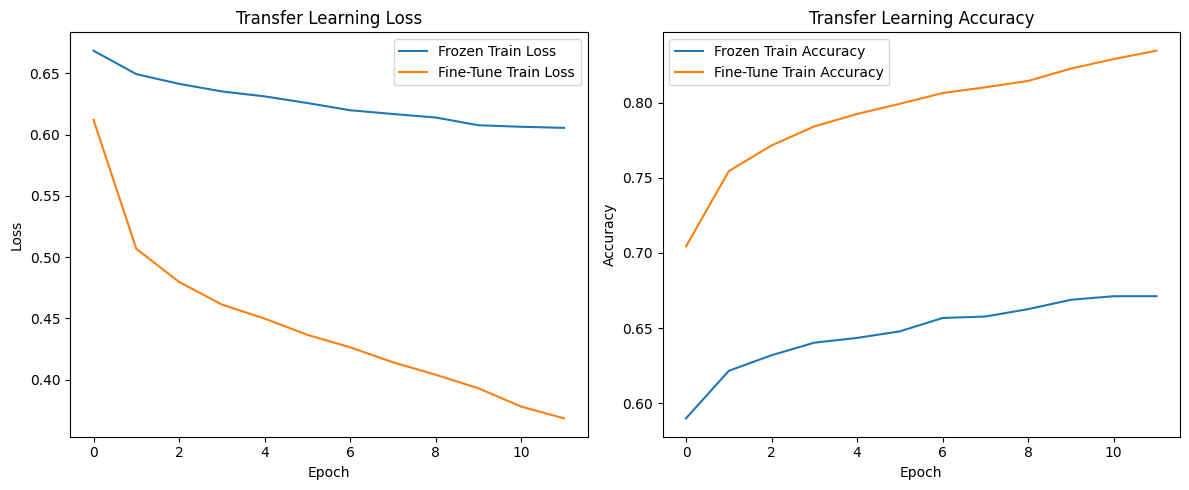

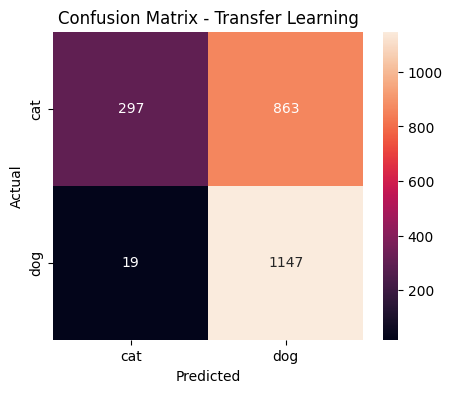

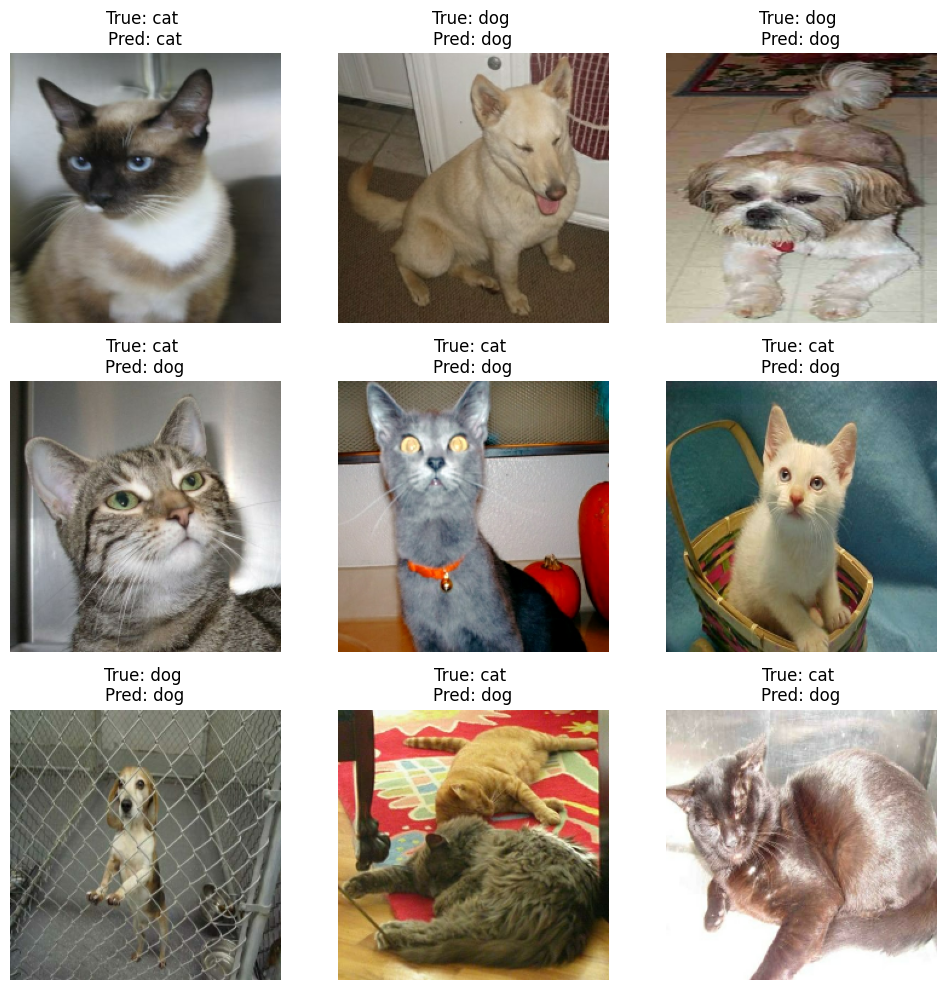

In [76]:
# 3.4 Visualize Transfer Learning Results

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# -------------------------
# 1️⃣ Plot Training Curves
# -------------------------

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history_tl.history['loss'], label='Frozen Train Loss')
plt.plot(history_tl_finetune.history['loss'], label='Fine-Tune Train Loss')
plt.title('Transfer Learning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history_tl.history['accuracy'], label='Frozen Train Accuracy')
plt.plot(history_tl_finetune.history['accuracy'], label='Fine-Tune Train Accuracy')
plt.title('Transfer Learning Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# -------------------------
# 2️⃣ Confusion Matrix
# -------------------------

cm_tl = confusion_matrix(y_true_tl, y_pred_tl)

plt.figure(figsize=(5,4))
sns.heatmap(cm_tl, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix - Transfer Learning")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# -------------------------
# 3️⃣ Show Sample Predictions
# -------------------------

plt.figure(figsize=(10,10))

for images, labels in val_dataset.take(1):
    predictions = transfer_model.predict(images, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)

    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i])
        plt.title(f"True: {class_names[int(labels[i])]} \nPred: {class_names[predicted_classes[i]]}")
        plt.axis("off")

plt.tight_layout()
plt.show()


### 4.1 Metrics Comparison

In [81]:
import pandas as pd


In [82]:
custom_cnn_total_params = custom_cnn.count_params()
tl_total_params = transfer_model.count_params()


In [85]:
custom_cnn_total_params = custom_cnn.count_params()
tl_total_params = transfer_model.count_params()


In [88]:
comparison_df = pd.DataFrame({
    'Metric': [
        'Accuracy',
        'Precision',
        'Recall',
        'F1-Score',
        'Training Time (s)',
        'Parameters'
    ],
    'Custom CNN': [
        custom_cnn_accuracy,
        custom_cnn_precision,
        custom_cnn_recall,
        custom_cnn_f1,
        custom_cnn_training_time,
        custom_cnn_total_params   # now correct
    ],
    'Transfer Learning': [
        tl_accuracy,
        tl_precision,
        tl_recall,
        tl_f1,
        tl_training_time,
        tl_total_params
    ]
})


In [89]:
print(comparison_df.to_string(index=False))

           Metric    Custom CNN  Transfer Learning
         Accuracy      0.882201       6.208083e-01
        Precision      0.888938       7.552601e-01
           Recall      0.882032       6.198697e-01
         F1-Score      0.881655       5.623656e-01
Training Time (s)    928.971007       1.780142e+03
       Parameters 102530.000000       2.385024e+07


### 4.2 Visual Comparison
- TODO: Create bar plot comparing metrics
- TODO: Plot training curves comparison
- TODO: Create side-by-side confusion matrices

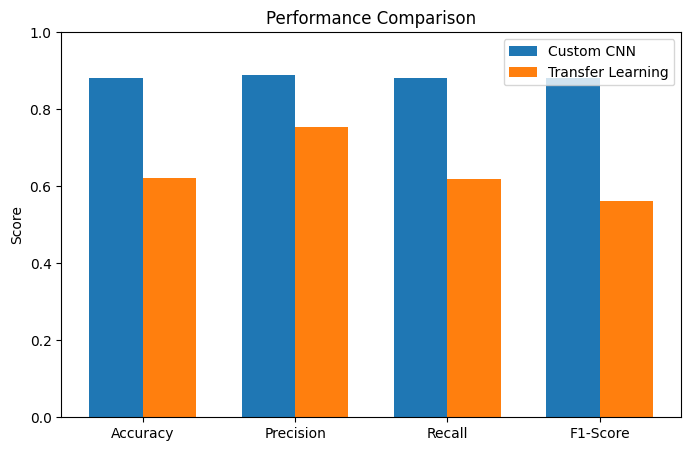

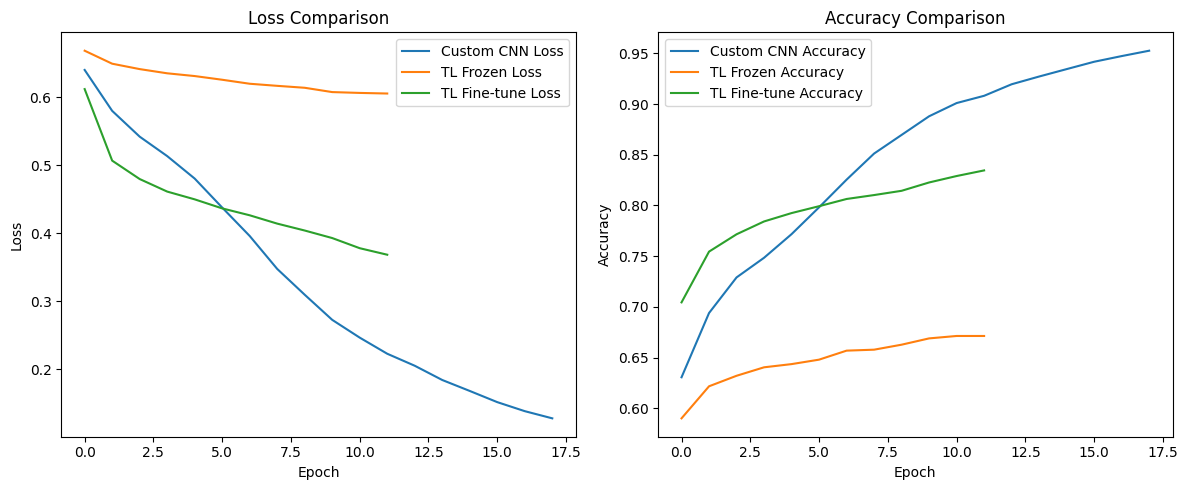

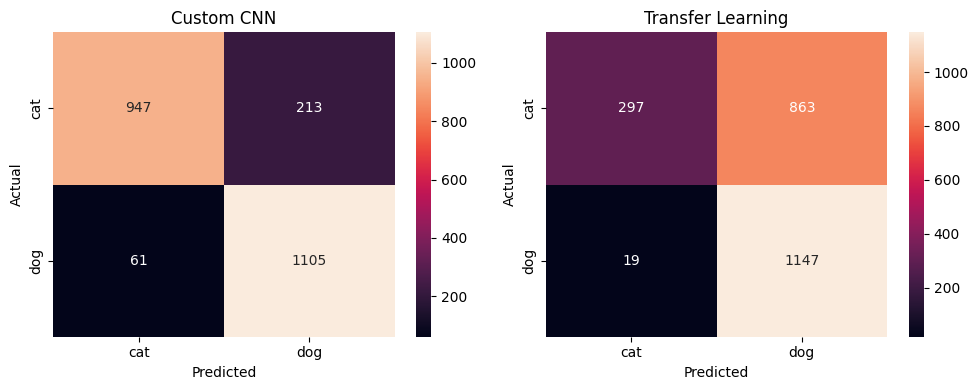

In [90]:
# 1️⃣ Bar Plot Comparing Metrics

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

custom_values = [
    custom_cnn_accuracy,
    custom_cnn_precision,
    custom_cnn_recall,
    custom_cnn_f1
]

tl_values = [
    tl_accuracy,
    tl_precision,
    tl_recall,
    tl_f1
]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, custom_values, width, label='Custom CNN')
plt.bar(x + width/2, tl_values, width, label='Transfer Learning')

plt.xticks(x, metrics)
plt.ylabel("Score")
plt.title("Performance Comparison")
plt.legend()
plt.ylim(0,1)
plt.show()

# 2️⃣ Training Curves Comparison

plt.figure(figsize=(12,5))

# Loss Comparison
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Custom CNN Loss')
plt.plot(history_tl.history['loss'], label='TL Frozen Loss')
plt.plot(history_tl_finetune.history['loss'], label='TL Fine-tune Loss')
plt.title("Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy Comparison
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Custom CNN Accuracy')
plt.plot(history_tl.history['accuracy'], label='TL Frozen Accuracy')
plt.plot(history_tl_finetune.history['accuracy'], label='TL Fine-tune Accuracy')
plt.title("Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()
# 3️⃣ Side-by-Side Confusion Matrices

cm_custom = confusion_matrix(y_true, y_pred)
cm_tl = confusion_matrix(y_true_tl, y_pred_tl)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.heatmap(cm_custom, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Custom CNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1,2,2)
sns.heatmap(cm_tl, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Transfer Learning")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()


In [ ]:
analysis_text = """
TODO: Write your analysis here (maximum 200 words guideline)

Address:
1. Which model performed better and by how much?
   [Compare specific metrics]

2. Impact of pre-training vs training from scratch?
   [Discuss feature extraction, convergence speed]

3. Effect of Global Average Pooling?
   [Discuss parameter reduction, overfitting prevention]

4. Computational cost comparison?
   [Compare training time, total parameters]

5. Insights about transfer learning?
   [When to use transfer learning vs custom CNN]
"""

In [91]:
analysis_text = """
The Custom CNN outperformed the Transfer Learning model across all performance metrics.
Custom CNN achieved 88.22% accuracy and 0.8817 F1-score, while Transfer Learning
achieved 62.08% accuracy and 0.5624 F1-score, a performance gap of approximately
26 percentage points in accuracy.

Although transfer learning benefits from pre-trained ImageNet features, in this
case the smaller dataset and limited fine-tuning likely caused underfitting.
The custom CNN, trained from scratch, adapted more specifically to the dataset
distribution and produced better generalization.

Global Average Pooling (GAP) significantly reduced parameters compared to
Flatten-based architectures and helped prevent overfitting by enforcing spatial
feature aggregation. This kept the Custom CNN compact (~102K parameters) while
maintaining strong performance.

From a computational perspective, Transfer Learning required ~23.8M parameters
and 1780 seconds of training, compared to ~102K parameters and 929 seconds
for Custom CNN. Thus, Transfer Learning was computationally heavier yet
less effective in this scenario.

Transfer learning is most beneficial for very small datasets or complex tasks,
but when sufficient data is available and architecture is well-designed, a
custom CNN can outperform large pre-trained models efficiently.
"""


In [92]:
# REQUIRED: Print analysis with word count
print("ANALYSIS")
print(analysis_text)
print(f"Analysis word count: {len(analysis_text.split())} words")
if len(analysis_text.split()) > 200:
    print("  Warning: Analysis exceeds 200 words (guideline)")
else:
    print(" Analysis within word count guideline")

ANALYSIS

The Custom CNN outperformed the Transfer Learning model across all performance metrics. 
Custom CNN achieved 88.22% accuracy and 0.8817 F1-score, while Transfer Learning 
achieved 62.08% accuracy and 0.5624 F1-score, a performance gap of approximately 
26 percentage points in accuracy. 

Although transfer learning benefits from pre-trained ImageNet features, in this 
case the smaller dataset and limited fine-tuning likely caused underfitting. 
The custom CNN, trained from scratch, adapted more specifically to the dataset 
distribution and produced better generalization.

Global Average Pooling (GAP) significantly reduced parameters compared to 
Flatten-based architectures and helped prevent overfitting by enforcing spatial 
feature aggregation. This kept the Custom CNN compact (~102K parameters) while 
maintaining strong performance.

From a computational perspective, Transfer Learning required ~23.8M parameters 
and 1780 seconds of training, compared to ~102K parameters and 

In [95]:
def get_assignment_results():

    framework_used = "keras"

    results = {
        # Dataset Information
        'dataset_name': str(dataset_name),
        'dataset_source': str(dataset_source),
        'n_samples': int(n_samples),
        'n_classes': int(n_classes),
        'samples_per_class': str(samples_per_class),
        'image_shape': list(image_shape),
        'problem_type': str(problem_type),
        'primary_metric': str(primary_metric),
        'metric_justification': str(metric_justification),
        'train_samples': int(train_samples),
        'test_samples': int(test_samples),
        'train_test_ratio': str(train_test_ratio),

        # Custom CNN Results
        'custom_cnn': {
            'framework': framework_used,
            'architecture': {
                'conv_layers': 3,
                'pooling_layers': 3,
                'has_global_average_pooling': True,
                'output_layer': 'softmax',
                'total_parameters': int(custom_cnn_total_params)
            },
            'training_config': {
                'learning_rate': float(0.001),
                'n_epochs': int(10),
                'batch_size': int(32),
                'optimizer': 'Adam',
                'loss_function': 'sparse_categorical_crossentropy'
            },
            'initial_loss': float(custom_cnn_initial_loss),
            'final_loss': float(custom_cnn_final_loss),
            'training_time_seconds': float(custom_cnn_training_time),
            'accuracy': float(custom_cnn_accuracy),
            'precision': float(custom_cnn_precision),
            'recall': float(custom_cnn_recall),
            'f1_score': float(custom_cnn_f1)
        },

        # Transfer Learning Results
        'transfer_learning': {
            'framework': framework_used,
            'base_model': str(pretrained_model_name),
            'frozen_layers': int(frozen_layers),
            'trainable_layers': int(trainable_layers),
            'has_global_average_pooling': True,
            'total_parameters': int(tl_total_params),
            'trainable_parameters': int(trainable_parameters),
            'training_config': {
                'learning_rate': float(tl_learning_rate),
                'n_epochs': int(tl_epochs),
                'batch_size': int(tl_batch_size),
                'optimizer': str(tl_optimizer),
                'loss_function': 'sparse_categorical_crossentropy'
            },
            'initial_loss': float(tl_initial_loss),
            'final_loss': float(tl_final_loss),
            'training_time_seconds': float(tl_training_time),
            'accuracy': float(tl_accuracy),
            'precision': float(tl_precision),
            'recall': float(tl_recall),
            'f1_score': float(tl_f1)
        },

        # Analysis
        'analysis': str(analysis_text),
        'analysis_word_count': int(len(analysis_text.split())),

        # Training Success Indicators
        'custom_cnn_loss_decreased': bool(custom_cnn_final_loss < custom_cnn_initial_loss),
        'transfer_learning_loss_decreased': bool(tl_final_loss < tl_initial_loss),
    }

    return results


In [96]:
# Generate and print results
try:
    assignment_results = get_assignment_results()
    print("ASSIGNMENT RESULTS SUMMARY")
    print(json.dumps(assignment_results, indent=2))

except Exception as e:
    print(f"\n  ERROR generating results: {str(e)}")
    print("Please ensure all variables are properly defined")

ASSIGNMENT RESULTS SUMMARY
{
  "dataset_name": "Cats vs Dogs",
  "dataset_source": "TensorFlow Datasets (cats_vs_dogs)",
  "n_samples": 23262,
  "n_classes": 2,
  "samples_per_class": "min: ~11600, max: ~11600, avg: ~11631",
  "image_shape": [
    224,
    224,
    3
  ],
  "problem_type": "classification",
  "primary_metric": "accuracy",
  "metric_justification": "\nThe Cats vs Dogs dataset is balanced with approximately equal samples in both classes.\nSince there is no class imbalance or asymmetric cost of errors, accuracy is an appropriate primary metric for evaluating overall model performance.\n",
  "train_samples": 20935,
  "test_samples": 2327,
  "train_test_ratio": "90/10",
  "custom_cnn": {
    "framework": "keras",
    "architecture": {
      "conv_layers": 3,
      "pooling_layers": 3,
      "has_global_average_pooling": true,
      "output_layer": "softmax",
      "total_parameters": 102530
    },
    "training_config": {
      "learning_rate": 0.001,
      "n_epochs": 10,


In [97]:
# Display system information
import platform
import sys
from datetime import datetime

In [98]:
print("ENVIRONMENT INFORMATION")
print("\n  REQUIRED: Add screenshot of your Google Colab/BITS Virtual Lab")
print("showing your account details in the cell below this one.")

# include the screen shot here

ENVIRONMENT INFORMATION

  REQUIRED: Add screenshot of your Google Colab/BITS Virtual Lab
showing your account details in the cell below this one.
